In [36]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tv
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import logging
import matplotlib.pyplot as plt
import copy
import pandas as pd
%matplotlib inline

In [37]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("training.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)

# Paths and parameters

In [38]:
train_img_dir= r"E:/lungs_segmentation/train/images/"
train_mask_dir =  r"E:/lungs_segmentation/train/masks/"
test_img_dir = r"E:/lungs_segmentation/test/images/"
test_mask_dir = r"E:/lungs_segmentation/test/masks/"
model_name = 'Unet'
project_name = "CT_lung_segmentation"
resize_size = (256, 256)

# Creating list of images and masks

In [39]:
def create_img_list(img_folder):
    img_list = []
    for (dirpath, dirnames, filenames) in os.walk(img_folder):
        img_list += [os.path.join(dirpath, file) for file in filenames]
    return img_list

In [40]:
train_img_list = create_img_list(train_img_dir)
test_img_list = create_img_list(test_img_dir)

if train_mask_dir:
    train_mask_img_list = create_img_list(train_mask_dir)
if test_mask_dir:
    test_mask_img_list = create_img_list(test_mask_dir)

In [41]:
def make_img_mask_pairs(img_list, mask_list):
    img_path_names =  {os.path.basename(n):n for n in img_list}
    mask_path_names =  {os.path.basename(n):n for n in mask_list}
    img_mask_pairs = {}
    for name, path in img_path_names.items():
        if name in mask_path_names.keys():
            img_mask_pairs[path] = mask_path_names[name]
    return(img_mask_pairs)

In [42]:
test_img_mask_pairs = make_img_mask_pairs(test_img_list,test_mask_img_list)

In [43]:
train_img_mask_pairs = make_img_mask_pairs(train_img_list,train_mask_img_list)

In [44]:
def train_val_split(img_dic, split_ratio):
    val_dic = {}
    train_dic = {}
    for i in range(int(len(img_dic)*split_ratio)):
        random_entry = random.choice(list(img_dic.keys()))
        val_dic[random_entry] = img_dic[random_entry]    
    for key in img_dic.keys():
        if key not in val_dic.keys():
            train_dic[key] = img_dic[key]
    return(train_dic, val_dic)

In [45]:
train_img_mask_pairs, val_img_mask_pairs = train_val_split(train_img_mask_pairs, 0.2)

# Image Loading functions

In [46]:
def get_img_transform():
    return tv.Compose([
        tv.ToTensor(),
        tv.Normalize((0), (1)),
        
    ])
def get_mask_transform():
    return tv.Compose([
        tv.ToTensor(),
    ])
transforms = (get_img_transform(),get_mask_transform())

In [47]:
class loadDataset(Dataset):
    def __init__(self,img_mask_pairs_dic, transforms):
        super().__init__()
        self.imgs = list(img_mask_pairs_dic.keys())
        self.masks = list(img_mask_pairs_dic.values())
        self.img_transform = transforms[0]
        self.mask_transform = transforms[1]
        
    def __getitem__(self, idx):
        image_path = self.imgs[idx]
        mask_path = self.masks[idx]
      ### Reading, converting and normalizing image
            ### Reading, converting and normalizing image
        img = Image.open(image_path)
        img = img.resize((resize_size[0], resize_size[1]))
            ### Doing the same for mask
        mask = Image.open(mask_path)
        mask = mask.resize((resize_size[0], resize_size[1]))
            ### Apply Transforms on image
        img = self.img_transform(img)
            
            # creating mask tensor as a label
        mask  = self.mask_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.imgs)

In [48]:
train_dataset = loadDataset(train_img_mask_pairs, transforms)
val_dataset = loadDataset(val_img_mask_pairs, transforms)
test_dataset = loadDataset(test_img_mask_pairs, transforms)

In [49]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 4,
    shuffle = True
)
val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 1,
    shuffle = True
)
test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 0,
    batch_size = 1,
    shuffle = True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


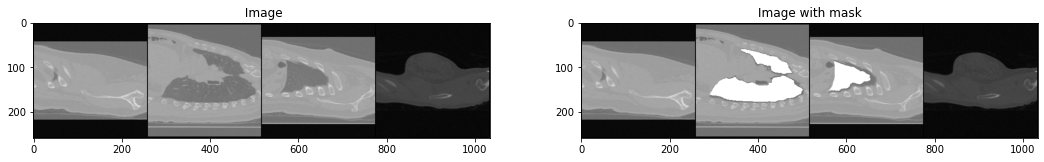

In [50]:
  def dataset_preview(train_data_loader):
    for image, mask in train_data_loader:
        masked_img = image + mask.int().float() 
        imgs = (image, masked_img)
        # https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib by YellowPillow
        n_row = 1
        n_col = 2
        _, axs = plt.subplots(n_row, n_col, figsize=(18, 18))
        axs = axs.flatten()
        titles = [' Image', 'Image with mask']
        for title, img, ax in zip(titles, imgs, axs):
            ax.imshow(make_grid(img, 4).permute(1,2,0))
            ax.set_title(title)
        plt.show()
        break
        
dataset_preview(train_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


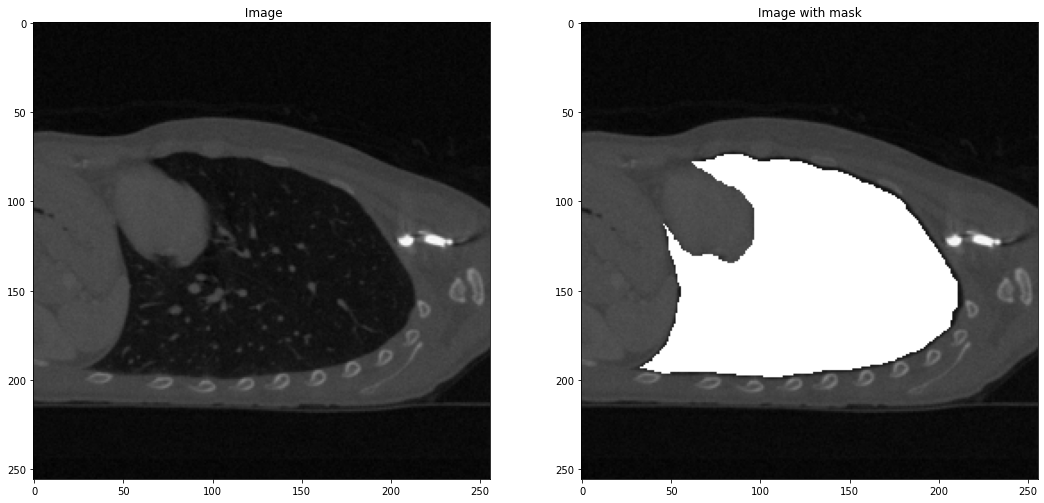

In [51]:
dataset_preview(test_data_loader)

# Functions for training

In [52]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
n_channels = 1
n_classes = 1
from UNet import UNet
model = UNet(n_channels, n_classes)

In [53]:
#from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class DiceBCELoss(nn.Module):
    # Return Dice and Dice loss
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_coefficient =  (2. * intersection + smooth) / (torch.sum(targets) + torch.sum(inputs) + smooth)
        
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE, dice_coefficient

In [54]:
class Optimizer:
    def __init__(self, model):
        self.optimizer_dict = {}
        self.optimizer_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr = 0.0001)
        self.optimizer_dict['lr_scheduler'] = torch.optim.lr_scheduler.StepLR(self.optimizer_dict['optimizer'], step_size = 5, gamma = 0.5)
        self.optimizer_dict['criterion'] = DiceBCELoss(nn.Module)

    def return_state_dict(self):
        return self.optimizer_dict['optimizer'].state_dict()


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizerA = Optimizer(model)

In [56]:
mylogs.info("Model: " + model_name )
# Loading model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")
model.to(device)
optimizerA = Optimizer(model)

Model: Unet
Model: Unet
Device is: cuda
Device is: cuda


In [57]:
def train_one_epoch(data_loader, optimizer_obj, phase):
    ## global to local
    optimizer = optimizer_obj.optimizer_dict['optimizer']
    criterion = optimizer_obj.optimizer_dict['criterion']
    lr_scheduler = optimizer_obj.optimizer_dict['criterion'] 
    ### Local Parameters
    epoch_loss = []
    epoch_dice = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in data_loader:
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        #Reseting Gradients
        optimizer.zero_grad()
        #Forward
        preds = model(images)
        #Calculating Loss
        _loss, dice_coefficient = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(float(loss))
        epoch_dice.append(float(dice_coefficient))
        #Backward if train phase
        if phase == "train":
            _loss.backward()
            optimizer.step()
    ###Overall Epoch Results
    end_time = time.time()
    total_time = int(end_time - start_time)/60
    ###Dice coefficient and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_dice = np.mean(epoch_dice)
    ###Storing results to logs
    return epoch_loss, epoch_dice, total_time

In [58]:
def report_in_progress(phase, epoch, loss, dice, _time):
       #Print epoch details
        mylogs.info(f'{"Training" if phase == False else "Validation"} Epoch {epoch}: | Loss: {loss:.5f} | Dice: {dice:.3f} | Time: {(round(_time, 4))}')

In [59]:
def train_model(model, optimizer_obj, max_n_epochs, early_stop_epoch_thresh = 15):
    start_time = time.time()
    # initializing  training stats
    train_logs =  {"loss" : [], "dice coefficient" : [], "time" : []}
    val_logs = {"loss" : [], "dice coefficient" : [], "time" : []} 
    mylogs.info("Training started")
    best_model = model
    best_epoch = 1
    best_val_dice = 0
    bad_dice_epoch = 0
    current_epoch = 0
    best_train_logs = {}
    best_val_logs = {}
    best_model_optimizer_state_dict = optimizer_obj.return_state_dict()
    for epoch in range(1, max_n_epochs + 1):
        if bad_dice_epoch < early_stop_epoch_thresh:
            current_epoch = epoch 
            ###Training
            train_loss, train_dice, train_time = train_one_epoch(train_data_loader, optimizer_obj, "train")
            #Print train Epoch Details      
            report_in_progress(0, epoch, train_loss, train_dice, train_time)
            #Adding stats for the epoch
            train_logs["loss"].append(train_loss)
            train_logs["dice coefficient"].append(train_dice)
            train_logs["time"].append(train_time)
            ###Validation
            val_loss, val_dice, val_time = train_one_epoch(val_data_loader, optimizer_obj, "validation")
            #Print Val Epoch  Details
            report_in_progress(1, epoch, val_loss, val_dice, val_time)
            #adding stats on the epoch
            val_logs["loss"].append(val_loss)
            val_logs["dice coefficient"].append(val_dice)
            val_logs["time"].append(val_time)
            # Early stop processing
            if val_dice > best_val_dice:
                best_val_dice = val_dice
                best_model = copy.deepcopy(model)
                bad_dice_epoch = 0
                best_train_logs = train_logs
                best_val_logs = val_logs
                best_epoch = epoch 
            else:
                bad_dice_epoch +=1
        else:
            mylogs.info(f"Early stop, best dice coefficient: {best_val_dice}%")
            break
    end_time = time.time()
    total_time = end_time - start_time
    mylogs.info(f"Total time : {int(total_time/60)}")
    # packing training data into a dictionary
    training_stats = {}
    training_stats['train logs'] = train_logs
    training_stats['validation logs'] = val_logs
    training_stats['best train logs'] = best_train_logs
    training_stats['best validation logs'] = best_val_logs
    training_stats['best validation dice'] = best_val_dice
    training_stats['best epoch'] = best_epoch
    training_stats['current epoch'] = current_epoch 
    
    return best_model, best_model_optimizer_state_dict, training_stats

In [60]:
# Training de novo
n_of_epochs = 120
model, model_optimizer_state_dict,  training_stats = train_model(model, optimizerA, n_of_epochs)

Training started
Training started
Training Epoch 1: | Loss: 0.83305 | Dice: 0.473 | Time: 2.0833
Training Epoch 1: | Loss: 0.83305 | Dice: 0.473 | Time: 2.0833
Validation Epoch 1: | Loss: 0.92021 | Dice: 0.436 | Time: 0.1833
Validation Epoch 1: | Loss: 0.92021 | Dice: 0.436 | Time: 0.1833
Training Epoch 2: | Loss: 0.50509 | Dice: 0.635 | Time: 2.1167
Training Epoch 2: | Loss: 0.50509 | Dice: 0.635 | Time: 2.1167
Validation Epoch 2: | Loss: 0.81457 | Dice: 0.500 | Time: 0.1833
Validation Epoch 2: | Loss: 0.81457 | Dice: 0.500 | Time: 0.1833
Training Epoch 3: | Loss: 0.33202 | Dice: 0.752 | Time: 2.1167
Training Epoch 3: | Loss: 0.33202 | Dice: 0.752 | Time: 2.1167
Validation Epoch 3: | Loss: 0.58376 | Dice: 0.586 | Time: 0.1667
Validation Epoch 3: | Loss: 0.58376 | Dice: 0.586 | Time: 0.1667
Training Epoch 4: | Loss: 0.21579 | Dice: 0.835 | Time: 2.1
Training Epoch 4: | Loss: 0.21579 | Dice: 0.835 | Time: 2.1
Validation Epoch 4: | Loss: 0.50343 | Dice: 0.618 | Time: 0.1667
Validation Ep

Training Epoch 33: | Loss: 0.05312 | Dice: 0.963 | Time: 2.5833
Training Epoch 33: | Loss: 0.05312 | Dice: 0.963 | Time: 2.5833
Validation Epoch 33: | Loss: 0.35812 | Dice: 0.714 | Time: 0.3
Validation Epoch 33: | Loss: 0.35812 | Dice: 0.714 | Time: 0.3
Training Epoch 34: | Loss: 0.04244 | Dice: 0.969 | Time: 2.45
Training Epoch 34: | Loss: 0.04244 | Dice: 0.969 | Time: 2.45
Validation Epoch 34: | Loss: 0.30643 | Dice: 0.735 | Time: 0.3167
Validation Epoch 34: | Loss: 0.30643 | Dice: 0.735 | Time: 0.3167
Training Epoch 35: | Loss: 0.04274 | Dice: 0.969 | Time: 2.45
Training Epoch 35: | Loss: 0.04274 | Dice: 0.969 | Time: 2.45
Validation Epoch 35: | Loss: 0.30222 | Dice: 0.739 | Time: 0.1667
Validation Epoch 35: | Loss: 0.30222 | Dice: 0.739 | Time: 0.1667
Training Epoch 36: | Loss: 0.03107 | Dice: 0.978 | Time: 2.65
Training Epoch 36: | Loss: 0.03107 | Dice: 0.978 | Time: 2.65
Validation Epoch 36: | Loss: 0.29569 | Dice: 0.741 | Time: 0.1667
Validation Epoch 36: | Loss: 0.29569 | Dice:

Training Epoch 65: | Loss: 0.02500 | Dice: 0.983 | Time: 2.6167
Training Epoch 65: | Loss: 0.02500 | Dice: 0.983 | Time: 2.6167
Validation Epoch 65: | Loss: 0.13703 | Dice: 0.873 | Time: 0.1667
Validation Epoch 65: | Loss: 0.13703 | Dice: 0.873 | Time: 0.1667
Training Epoch 66: | Loss: 0.03254 | Dice: 0.975 | Time: 2.5833
Training Epoch 66: | Loss: 0.03254 | Dice: 0.975 | Time: 2.5833
Validation Epoch 66: | Loss: 0.16703 | Dice: 0.843 | Time: 0.2333
Validation Epoch 66: | Loss: 0.16703 | Dice: 0.843 | Time: 0.2333
Training Epoch 67: | Loss: 0.02678 | Dice: 0.981 | Time: 2.4833
Training Epoch 67: | Loss: 0.02678 | Dice: 0.981 | Time: 2.4833
Validation Epoch 67: | Loss: 0.12408 | Dice: 0.887 | Time: 0.2833
Validation Epoch 67: | Loss: 0.12408 | Dice: 0.887 | Time: 0.2833
Training Epoch 68: | Loss: 0.02783 | Dice: 0.981 | Time: 2.4667
Training Epoch 68: | Loss: 0.02783 | Dice: 0.981 | Time: 2.4667
Validation Epoch 68: | Loss: 0.10619 | Dice: 0.904 | Time: 0.25
Validation Epoch 68: | Loss:

Training Epoch 97: | Loss: 0.02209 | Dice: 0.985 | Time: 2.6167
Training Epoch 97: | Loss: 0.02209 | Dice: 0.985 | Time: 2.6167
Validation Epoch 97: | Loss: 0.04587 | Dice: 0.963 | Time: 0.1833
Validation Epoch 97: | Loss: 0.04587 | Dice: 0.963 | Time: 0.1833
Training Epoch 98: | Loss: 0.02228 | Dice: 0.985 | Time: 2.6333
Training Epoch 98: | Loss: 0.02228 | Dice: 0.985 | Time: 2.6333
Validation Epoch 98: | Loss: 0.04597 | Dice: 0.963 | Time: 0.1833
Validation Epoch 98: | Loss: 0.04597 | Dice: 0.963 | Time: 0.1833
Training Epoch 99: | Loss: 0.03584 | Dice: 0.976 | Time: 2.6167
Training Epoch 99: | Loss: 0.03584 | Dice: 0.976 | Time: 2.6167
Validation Epoch 99: | Loss: 0.11428 | Dice: 0.901 | Time: 0.1833
Validation Epoch 99: | Loss: 0.11428 | Dice: 0.901 | Time: 0.1833
Training Epoch 100: | Loss: 0.03450 | Dice: 0.976 | Time: 2.65
Training Epoch 100: | Loss: 0.03450 | Dice: 0.976 | Time: 2.65
Validation Epoch 100: | Loss: 0.06440 | Dice: 0.947 | Time: 0.1667
Validation Epoch 100: | Los

# Saving and visualization

In [61]:
def train_vis(training_stats):

    ### Plotting Results
    train_logs = training_stats['train logs']
    val_logs = training_stats['validation logs']
    epochs = training_stats['current epoch'] + 1
    best_epoch = training_stats['best epoch'] 

#Loss
    plt.figure(figsize=(15, 6))
    
    plt.title("Loss",color='black')
    plt.plot(np.arange(1, epochs), train_logs["loss"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["loss"], color = 'orange', label='Validation')
    plt.axvline(x=best_epoch,color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Loss", color = 'black')
    plt.show()

# dice coefficient
    plt.figure(figsize=(15, 6))
    plt.title("Dice", color='black')
    plt.plot(np.arange(1, epochs), train_logs["dice coefficient"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["dice coefficient"], color = 'orange', label='Validation')
    plt.axvline(x=best_epoch, color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Accuracy", color='black')
    plt.show()

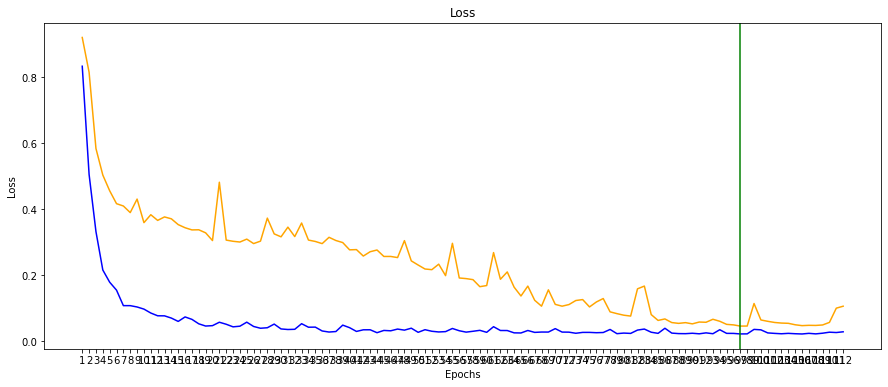

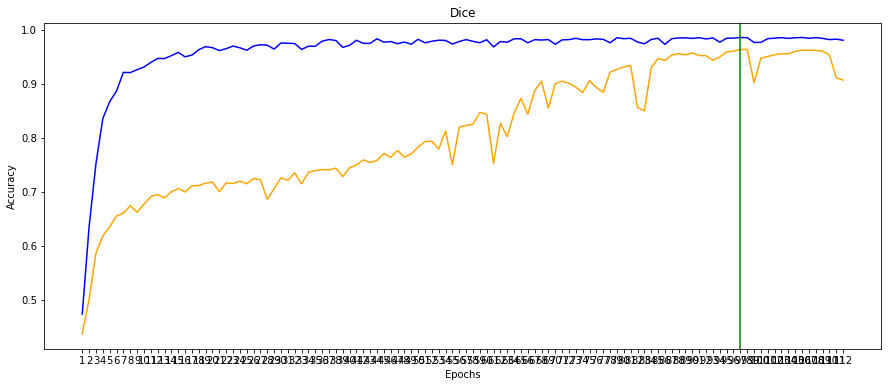

In [62]:
train_vis(training_stats)

In [63]:
# Saving the best model
def save_model(model, model_name,training_stats, parameters, img_lists):
    ''' Save model either for inference or for continuing training '''
    torch.save({'model_name': model_name,
                'parameters': (resize, n_channels, n_classes),
                'model_state_dict': model.state_dict(),
                'parameters': (resize_size, n_channels, n_classes)
                }, f'{project_name}_{model_name}_inference.pt')
        
    torch.save({'model_name': model_name,
                'model_state_dict': model.state_dict(),
                'model_stats': training_stats,
                'parameters': (resize, n_channels, n_classes),
                'img_lists': img_lists
                }, f'{project_name}_{model_name}.pt')
    mylogs.info("Model saved")

In [64]:
n_channels = 1
n_classes = 1
img_lists = (train_img_mask_pairs, val_img_mask_pairs, test_img_mask_pairs)
save_model(model, model_name, training_stats, (resize, n_channels,n_classes),  img_lists)

Model saved
Model saved


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


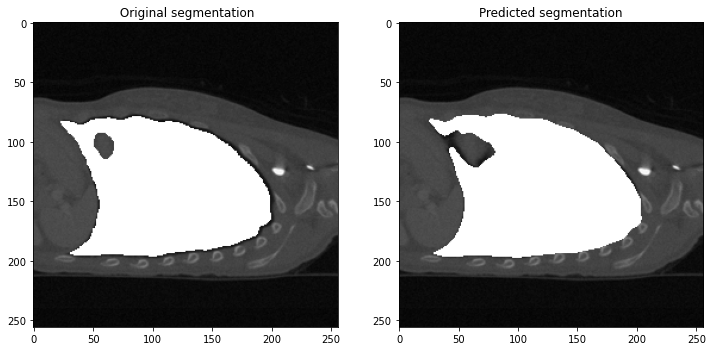

In [65]:
# Testing on a random test image 
def dataset_preview(test_data_loader):
    for image, actual_mask in test_data_loader:
        image.to('cpu')
        actual_mask.to('cpu')
        model.to('cpu')
        actual_masked_img = image + actual_mask.int().float()
        prediction_mask = model(image)
        prediction_mask[prediction_mask > 0] = 1
        prediction_mask[prediction_mask <= 0] = 0
        predicted_masked_img = image + prediction_mask.int().float()

        masked_imgs = (actual_masked_img, predicted_masked_img)
        n_row = 1
        n_col = 2
        # https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib by YellowPillow
        _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
        axs = axs.flatten()
        titles = [' Original segmentation', 'Predicted segmentation']
        for title, img, ax in zip(titles, masked_imgs, axs):
            ax.imshow(make_grid(img, 4).permute(1,2,0))
            ax.set_title(title)
        plt.show()
        break
    

dataset_preview(test_data_loader)